In [68]:
import pandas as pd
import numpy as np
import price_data as price
import ccxt
import chart
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# import the data from the csv file
price_data_csv = pd.read_csv("data/Bitfinex_ETHUSD_1h.csv")

price_data_csv['datetime'] = pd.to_datetime(price_data_csv['date'])

In [69]:
price_data_csv

,unix,date,symbol,open,high,low,close,Volume USD,Volume ETH,datetime
0,1673913600000,2023-01-17 00:00:00,ETH/USD,1577.00,1582.60,1559.30,1566.10,1.811644e+06,1156.786758,2023-01-17 00:00:00
1,1673910000000,2023-01-16 23:00:00,ETH/USD,1580.70,1583.00,1573.90,1577.40,3.461769e+05,219.460448,2023-01-16 23:00:00
2,1673906400000,2023-01-16 22:00:00,ETH/USD,1580.40,1586.60,1579.90,1580.70,4.548107e+05,287.727393,2023-01-16 22:00:00
3,1673902800000,2023-01-16 21:00:00,ETH/USD,1588.30,1588.40,1575.00,1580.70,1.711546e+06,1082.776975,2023-01-16 21:00:00
4,1673899200000,2023-01-16 20:00:00,ETH/USD,1591.70,1600.00,1586.00,1587.60,1.167355e+06,735.295196,2023-01-16 20:00:00
...,...,...,...,...,...,...,...,...,...,...
40966,1526378400,2018-05-15 10:00:00,ETH/USD,728.44,739.30,725.52,735.21,7.197618e+06,9822.410000,2018-05-15 10:00:00
40967,1526374800,2018-05-15 09:00:00,ETH/USD,731.32,732.00,728.44,728.44,2.111099e+06,2889.590000,2018-05-15 09:00:00
40968,1526371200,2018-05-15 08:00:00,ETH/USD,734.64,734.65,722.00,731.32,7.891317e+06,10826.460000,2018-05-15 08:00:00
40969,1526367600,2018-05-15 07:00:00,ETH/USD,733.04,735.99,731.70,734.64,2.044880e+06,2785.610000,2018-05-15 07:00:00


In [70]:

def autocorrelation(time_series, lag=1):
    """
    Calculates the autocorrelation of a time series at a given lag.
    
    Parameters:
        time_series (list or numpy array): The time series data
        lag (int): The lag at which to calculate the autocorrelation
    
    Returns:
        float: The autocorrelation at the given lag
    """
    # Calculate the mean and standard deviation of the time series
    mean = np.mean(time_series)
    std = np.std(time_series)
    
    # Calculate the numerator of the autocorrelation formula
    numerator = np.sum((time_series[lag:] - mean) * (time_series[:-lag] - mean))
    
    # Calculate the denominator of the autocorrelation formula
    denominator = (len(time_series) - lag) * std**2
    
    # Calculate and return the autocorrelation
    return numerator / denominator
class Context: 
    def __init__(self, price_data, calculation_window, trade_side, context_window=10):
        self.price_data = price_data
        self.calculation_window = calculation_window
        self.context_window = context_window
        self.context_sequence = self.calculate_context_sequence()
        self.trade_side = trade_side
    
    def calculate_context_sequence(self):
        self.context_window
        current_price = price_data.iloc[-1]['open']
        moving_average_channel = chart.ma_channel(price_data, self.calculation_window)
        # ratio between last 10 open prices and the corresponding upper and lower bounds of the moving average channel
        open_prices = price_data.iloc[-self.context_window:]['open']
        # upper_bounds = moving_average_channel.iloc[-self.context_window:]['high']
        # lower_bounds = moving_average_channel.iloc[-self.context_window:]['low']
        # open_upper_ratio = (open_prices-upper_bounds)/(upper_bounds-lower_bounds)
        # open_lower_ratio = (open_prices-lower_bounds)/(upper_bounds-lower_bounds)
        # upper_lower__open_ratio = (upper_bounds-lower_bounds)/(open_prices)
        # normalised_atr = chart.get_normalised_atr(price_data, self.calculation_window).iloc[-self.context_window:]
        # print all lengths 
        # context_sequence = np.array([open_upper_ratio, open_lower_ratio, upper_lower__open_ratio, normalised_atr])
        return context_sequence.T

    def get_context_sequence(self):
        trade = 0
        if self.trade_side == 'long':
            trade = 1
        return (trade,self.context_sequence)
        
        


def identify_trend_variable(price_data, channel_period, no_opens=5, minute=False): #using moving average channel
    channel=chart.ma_channel(price_data,channel_period)
    
    upper_bound=channel.iloc[-no_opens:]['high']
    lower_bound=channel.iloc[-no_opens:]['low']

    if minute:
        opens=price_data.iloc[-no_opens:]['close']
    else:
        opens=price_data.iloc[-no_opens:]['open']
    try:
        if (opens>upper_bound).all():
            return 'uptrend'
        elif (opens<lower_bound).all():
            return 'downtrend'
        else:
            return 'neutral'
    except:
        print(opens, upper_bound, lower_bound)

# price_data = price.get_price_data('1h', symbol='ETH/USD')
price_data = price.get_price_data(data=price_data_csv, timeframe='1h')
print(f"Datapoints: {len(price_data)/24}")

def backtest_trend_strategy(price_data, no_opens, ma_channel_window):

    balance = 1000.0
    position = None
    # ma_channel_window = 24
    # no_opens = 2
    trades =[]
    contextual_data = []
    for i, row in price_data.iterrows():
        print(f'Processing: {(i/len(price_data))*100:.2f}%', end='\r')
        if i>ma_channel_window+no_opens:
            
            # Get the open, high, low, and close prices
            current_time = row['unix']
            open_price = row["open"]
            high_price = row["high"]
            low_price = row["low"]

            current_price_data = price_data.iloc[0:i]
            if position == 'long':
                profit = (open_price - entry)/entry
            elif position == 'short':
                profit = (entry - open_price)/entry
            channel = chart.ma_channel(current_price_data, ma_channel_window)
            trend = identify_trend_variable(current_price_data,ma_channel_window,no_opens)
            # long_term_trend = identify_trend_variable(current_price_data,ma_channel_window,no_opens+1)

            # entry conditions 
            if position == None:
                # if long_term_trend != trend:
                if trend == 'uptrend': 
                    position = "long"
                    timestamp = row['unix']
                    entry = open_price
                elif trend == 'downtrend':
                    position = "short"
                    timestamp = row['unix']
                    entry = open_price
                # trade_context = Context(current_price_data, ma_channel_window, position)

            # exit condition
            # essentially mean reversion
            # if the open_price is above the entry price and below the top of the channel, or the open_price is below the entry price and above the bottom of the channel, exit
            elif (open_price<channel.iloc[-1]['high'] and open_price>entry) or (open_price>channel.iloc[-1]['low'] and open_price<entry) or profit<-0.01:            # calculate the profit/loss and add it to the balance
                # append trade to end of list
                prev_balance = balance
                if position == "long":
                    balance += ((open_price - entry)/entry)*balance
                elif position == "short":
                    balance += ((entry - open_price)/entry)*balance
                trades.append((pd.to_datetime(timestamp, unit='ms'), pd.to_datetime(current_time, unit='ms'),position, open_price, entry, balance, prev_balance<balance, open_price<channel.iloc[-1]['high'] and open_price>entry, open_price>channel.iloc[-1]['low']and open_price<entry))
                # contextual_data.append((trade_context.get_context_sequence(), prev_balance<balance))
                timestamp=None
                position = None
                
        # if balance<=0:
        #     break

    trades_df = pd.DataFrame(trades, columns=['timestamp', 'timestamp_exit','side', 'exit', 'entry', 'balance', 'win', 'open_below_channel_high', 'open_above_channel_low'])
    win_rate = trades_df['win'].sum()/len(trades_df)
    print(f"Win rate: {win_rate:.2f}")
    # Calculate the overall performance of the strategy
    roi = (balance - 1000.0) / 1000.0
    print(f"ROI: {roi:.2f}")
    return balance, trades_df, contextual_data


def backtest_mean_reversion_strategy(price_data, no_opens, ma_channel_window):

    balance = 1000.0
    position = None
    # ma_channel_window = 24
    # no_opens = 2
    trades =[]
    contextual_data = []
    for i, row in price_data.iterrows():
        print(f'Processing: {(i/len(price_data))*100:.2f}%', end='\r')
        if i>ma_channel_window+no_opens:
            
            # Get the open, high, low, and close prices
            current_time = row['unix']
            open_price = row["open"]
            high_price = row["high"]
            low_price = row["low"]
            close_price = row["close"]

            current_price_data = price_data.iloc[0:i]
            if position == 'long':
                profit = (open_price - entry)/entry
            elif position == 'short':
                profit = (entry - open_price)/entry
            channel = chart.ma_channel(current_price_data, ma_channel_window)
            trend = identify_trend_variable(current_price_data,ma_channel_window,no_opens)
            # long_term_trend = identify_trend_variable(current_price_data,ma_channel_window,no_opens+1)

            # entry conditions 
            if position == None:
                # if long_term_trend != trend:
                if trend == 'uptrend': 
                    position = "short"
                    timestamp = row['unix']
                    entry = open_price
                elif trend == 'downtrend':
                    position = "long"
                    timestamp = row['unix']
                    entry = open_price
                # trade_context = Context(current_price_data, ma_channel_window, position)

            # exit condition
            # essentially mean reversion
            # if the open_price is above the entry price and below the top of the channel, or the open_price is below the entry price and above the bottom of the channel, exit
            elif (open_price<channel.iloc[-1]['high'] and open_price>entry) or (open_price>channel.iloc[-1]['low'] and open_price<entry) or profit<-0.01:            # calculate the profit/loss and add it to the balance
                # append trade to end of list
                prev_balance = balance
                if position == "long":
                    balance += ((open_price - entry)/entry)*balance
                elif position == "short":
                    balance += ((entry - open_price)/entry)*balance
                trades.append((pd.to_datetime(timestamp, unit='ms'), pd.to_datetime(current_time, unit='ms'),position, open_price, entry, balance, prev_balance<balance, open_price<channel.iloc[-1]['high'] and open_price>entry, open_price>channel.iloc[-1]['low']and open_price<entry))
                # contextual_data.append((trade_context.get_context_sequence(), prev_balance<balance))
                timestamp=None
                position = None
                
        # if balance<=0:
        #     break

    trades_df = pd.DataFrame(trades, columns=['timestamp', 'timestamp_exit','side', 'exit', 'entry', 'balance', 'win', 'open_below_channel_high', 'open_above_channel_low'])
    print(trades_df)
    win_rate = trades_df['win'].sum()/len(trades_df)
    print(f"Win rate: {win_rate:.2f}")
    # Calculate the overall performance of the strategy
    roi = (balance - 1000.0) / 1000.0
    print(f"ROI: {roi:.2f}")
    return balance, trades_df, contextual_data


# for hourly data it seems around 130 is the best option for the moving channel window
# for minute data it seems around 23 is the best option for the moving channel window

# fib_array = [5,8,13,21,34,55,89,144,233,377,610]
# ma_channel_period = [126,128,130,132]
# no_opens = [2,3,4,5,6]
# results = []
# for ma in ma_channel_period:
#     for no in no_opens:
#         balance, _ = backtest_strategy(price_data, no, ma)
#         print(f"ma_channel_period: {ma}, no_opens: {no}, final balance: {balance:.2f}")
#         results.append((ma, no, balance))

# results_df = pd.DataFrame(results, columns=['ma_channel_period', 'no_opens', 'balance'])
# results_df.sort_values(by='balance', ascending=True, inplace=True)
# print(results_df)

# print the timestamp of the first and last rows of price_data
# balance, trades_df, training_data = backtest_mean_reversion_strategy(price_data, 4, 128)
balance, trades_df, training_data = backtest_trend_strategy(price_data, 4, 128)
# with open('data/mean_reversion_training_data.pkl', 'wb') as f:
#     pickle.dump(training_data, f)

Datapoints: 1707.125
Win rate: 0.120.00%
ROI: 17.61


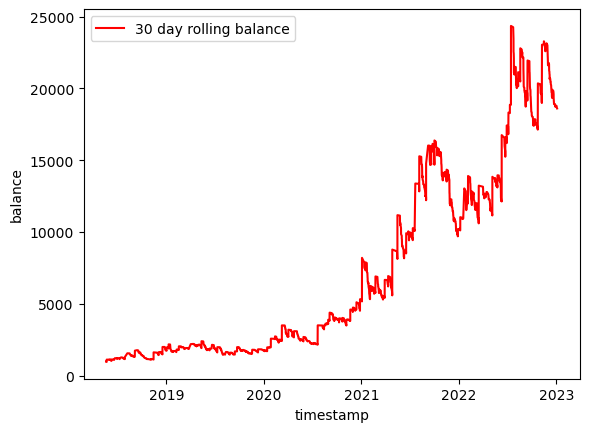

<AxesSubplot: xlabel='timestamp', ylabel='rolling_balance_deriv'>

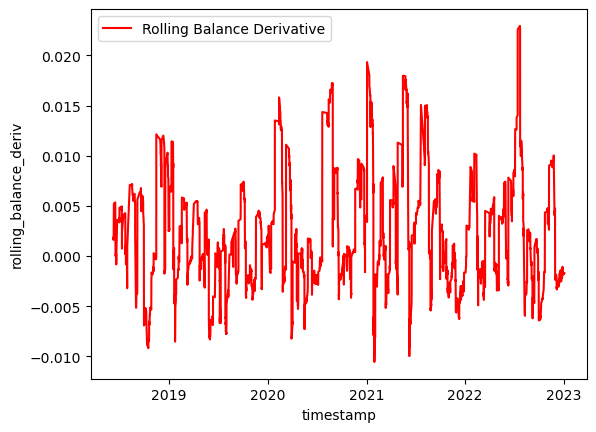

In [76]:
window = 30
trades_df['rolling_balance'] = np.log(trades_df['balance']).rolling(window=window).mean()
trades_df['rolling_balance_deriv'] = trades_df['rolling_balance'].diff()
bad_days = trades_df[trades_df['rolling_balance_deriv']<0]
# sns.scatterplot(x='timestamp', y='balance', data=trades_df)
sns.lineplot(x='timestamp', y='balance', data=trades_df, color='red', label=f'{str(window)} day rolling balance')
plt.show()
# # only show the rows from trades_df where win is false
# losses = trades_df[trades_df['win']==False]
wins = trades_df[trades_df['win']==True]
# # calculate the average loss by taking the differnce between the entry and exit price and dividing by the entry price
# loss = abs(losses['entry']-losses['exit'])/losses['entry']
win = abs(wins['entry']-wins['exit'])/wins['entry']
# print(trades_df)
# print(win.mean()/loss.mean())
sns.lineplot(x='timestamp', y='rolling_balance_deriv', data=trades_df, color='red', label='Rolling Balance Derivative')

In [72]:
bad_days

,timestamp,timestamp_exit,side,exit,entry,balance,win,open_below_channel_high,open_above_channel_low,rolling_balance,rolling_balance_deriv
39,2018-06-16 06:00:00,2018-06-16 17:00:00,short,500.03,497.65,1119.515893,False,True,False,1091.653791,-0.008436
43,2018-06-18 23:00:00,2018-06-19 00:00:00,long,517.64,517.97,1111.301692,False,False,True,1091.557272,-0.807030
44,2018-06-19 01:00:00,2018-06-19 02:00:00,long,517.57,520.07,1105.959615,False,False,True,1090.618861,-0.938411
45,2018-06-19 03:00:00,2018-06-19 04:00:00,long,515.34,515.82,1104.930456,False,False,True,1090.533452,-0.085409
46,2018-06-19 05:00:00,2018-06-19 06:00:00,long,516.71,516.78,1104.780789,False,False,True,1090.373402,-0.160049
...,...,...,...,...,...,...,...,...,...,...,...
2490,2023-01-01 22:00:00,2023-01-01 23:00:00,long,1202.60,1203.90,18761.159312,False,False,True,18970.702625,-32.912046
2491,2023-01-02 00:00:00,2023-01-02 01:00:00,long,1199.70,1201.90,18726.818227,False,False,True,18937.678010,-33.024615
2492,2023-01-02 08:00:00,2023-01-03 15:00:00,long,1212.00,1215.10,18679.041800,False,False,True,18903.331879,-34.346131
2493,2023-01-03 16:00:00,2023-01-03 17:00:00,long,1208.80,1213.00,18614.365810,False,False,True,18870.016749,-33.315130


In [73]:
import pickle

with open('data/mean_reversion_training_data.pkl', 'rb') as f:
    data = pickle.load(f)

len(data)

9976

In [74]:
# new_data = []
# for datapoint in data:
#     outcome = 0
#     if datapoint[2]:
#         outcome = 1
#     new_data.append((datapoint[1][0], datapoint[1][1], outcome))

# new_data

In [75]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(units, input_shape=(timesteps, input_dim)))
model.add(tf.keras.layers.Dense(output_dim))
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.fit(x_train, y_train, epochs=10)


ModuleNotFoundError: No module named 'tensorflow'